# Train Classifiers on sub-sampled data

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [55]:
import numpy as np
import pandas as pd
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import GreedyInfoMax
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [3]:
folder = 'E:/OneDrive - Sectra/Research/2020/project_dataembedding/greedyinfomax/experiments/experiment_color_no_domain'

In [4]:
df_train = pd.read_csv(f'{folder}/training_patches.csv')

e:\.venvs\notebooks-bapbuhj6\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
outputs = np.load(f'{folder}/outputs.npy')

In [6]:
out_array = np.stack(outputs, axis=0)
print(out_array.shape)
print(len(df_train))

(100817, 1024)
100817


## Plot points

In [20]:
import umap
# UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(out_array)
embedding.shape

e:\.venvs\notebooks-bapbuhj6\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\.venvs\notebooks-bapbuhj6\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
e:\.venvs\notebooks-bapbuhj6\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\.venvs\notebooks-bapbuhj6\lib\site-packages\umap\r

(100817, 2)

In [21]:
df_train['x'] = embedding[:, 0]
df_train['y'] = embedding[:, 1]

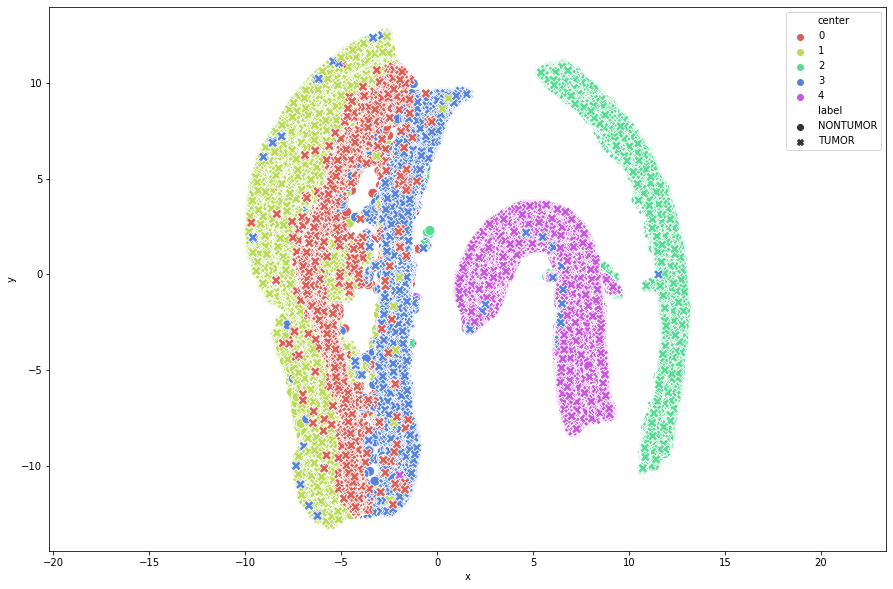

In [22]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='x', y='y', hue='center', style='label', data=df_train, s=100, palette=sns.color_palette("hls", 5))#, legend=None)
g = plt.gca().set_aspect('equal', 'datalim')

# Reduce dimentionality with PCA

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(out_array)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.14512223 0.13794161 0.10617355 0.0986511  0.08885659 0.0683343
 0.04971762 0.04073902 0.03194766 0.0292219  0.02651015 0.02411865
 0.02052368 0.01874607 0.01457555 0.01256    0.00920161 0.00690485
 0.0056693  0.00440229 0.00416527 0.00367204 0.00359501 0.00312278
 0.00281983 0.00251227 0.00236012 0.00222148 0.001843   0.001601  ]
[385.92566  376.25677  330.0995   318.19083  301.9823   264.8232
 225.88731  204.47581  181.07405  173.17726  164.94637  157.3306
 145.13237  138.7049   122.30639  113.53547   97.17815   84.18094
  76.27839   67.21655   65.38202   61.389     60.741688  56.61188
  53.79573   50.777363  49.215717  47.74832   43.49098   40.53525 ]


In [8]:
out_array_pca30 = pca.transform(out_array)

In [9]:
np.sum(pca.explained_variance_ratio_)

0.9678305632439201

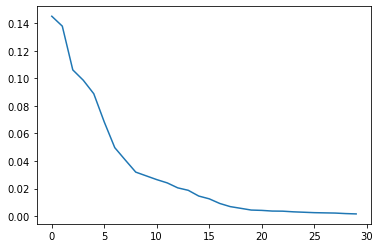

In [10]:
plt.plot(pca.explained_variance_ratio_)

# Sampling methods

In [11]:
X = out_array_pca30

## Weighted Random Sampling

For each point in the dataset, calculate a kernel density. Then do weighted sampling of the data by the inverse of the kernel. Samples with high density (i.e., a lot of samples around it) have lower probability than other.  

In [69]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)


In [73]:
densities = kde.score_samples(X)

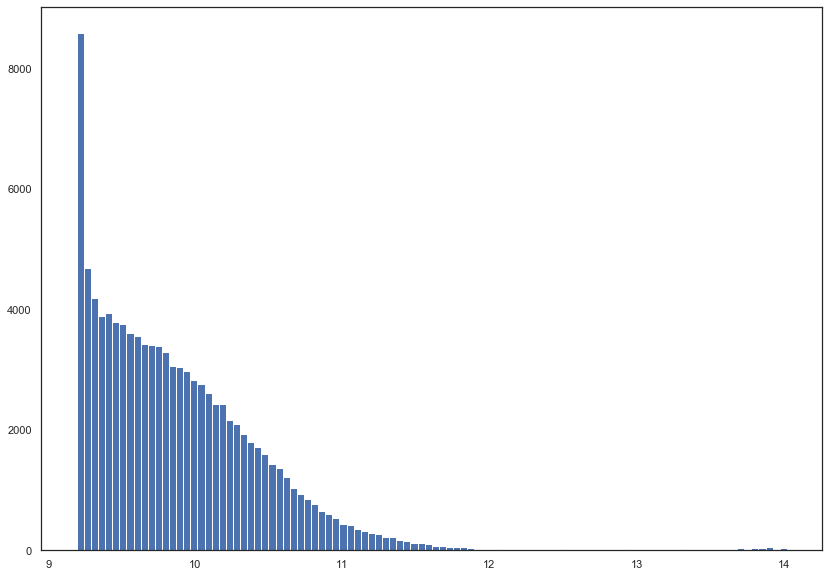

In [93]:
_ = plt.hist(densities, bins=100)

In [76]:
inversed_densities = 1/densities # Assign low values to areas with high density and vice versa

In [94]:
df_samples = df_train.sample(10000, weights=inversed_densities, axis=0)

In [95]:
df_samples

,Unnamed: 0,patch_id,app_magnification,app_patch_size,app_version,label,position_x,position_y,rater,request_id,result_id,row_version,slide_id,center,filename,x,y,kmeans_cluster
47854,122904,7e4a546796db83590e37e186d0fb904c479b7dd8114fb7...,20.0,256,1.0.0.dev0 UDI: (01)07350092810104(8012)1.0,NONTUMOR,0.303192,0.485841,None,None,310,1,1.2.752.24.16.2.3752269334.1083151721.37321168...,4,camelyon17_imagedata/7e4a546796db83590e37e186d...,4.278611,1.422500,9308
59411,142725,f63b1b4454bf8066c9fb6200d637b9c6ffd54a4f322a65...,20.0,256,NaN,TUMOR,0.475256,0.561122,NaN,None,252,1,1.2.752.24.16.2.1849791917.1311772851.23387765...,2,camelyon17_imagedata/f63b1b4454bf8066c9fb6200d...,11.758645,-1.124425,3463
95938,191853,5fc60395f0bbe3a5faa18f81fd3038313f2dd56c00c70d...,20.0,256,NaN,TUMOR,0.593783,1.596209,NaN,None,149,1,1.2.752.24.16.2.2301750427.1130221034.23561342...,0,camelyon17_imagedata/5fc60395f0bbe3a5faa18f81f...,-4.563876,-8.825101,9128
86757,177635,381b8810dddbe474bbe9c2c9e81a14f28e0322760a3350...,20.0,256,NaN,TUMOR,0.512972,0.137228,NaN,None,207,1,1.2.752.24.16.2.700767962.1181038233.387838505...,4,camelyon17_imagedata/381b8810dddbe474bbe9c2c9e...,4.469495,3.557432,5191
95931,191846,e5ece46141e3082fd5d213b6b1511d5ebdffa5c0606ba5...,20.0,256,NaN,TUMOR,0.570432,1.597877,NaN,None,149,1,1.2.752.24.16.2.2301750427.1130221034.23561342...,0,camelyon17_imagedata/e5ece46141e3082fd5d213b6b...,-6.705518,-1.109021,8949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18465,38479,0645f27c8d3f3408b92ae21b19d88730e4a27f41c9ff9e...,20.0,256,1.0.0.dev0 UDI: (01)07350092810104(8012)1.0,NONTUMOR,0.413583,0.714308,None,None,276,1,1.2.752.24.16.2.435165689.1159537174.405776300...,1,camelyon17_imagedata/0645f27c8d3f3408b92ae21b1...,-6.596602,-9.639028,2775
49285,124335,bc5daba7e673857e0ec013f871719bf52b3ffcb17601f2...,20.0,256,1.0.0.dev0 UDI: (01)07350092810104(8012)1.0,NONTUMOR,0.311459,0.478464,None,None,310,1,1.2.752.24.16.2.3752269334.1083151721.37321168...,4,camelyon17_imagedata/bc5daba7e673857e0ec013f87...,2.813704,-1.418358,1882
3840,13858,27345b1834aa9d7c46bcd3047c2338b2630e2e9d6cf7c0...,20.0,256,1.0.0.dev0 UDI: (01)07350092810104(8012)1.0,NONTUMOR,0.486994,1.009682,None,None,262,2,1.2.752.24.16.2.2301750427.1130221034.23561342...,0,camelyon17_imagedata/27345b1834aa9d7c46bcd3047...,-4.327265,-11.463235,4890
38312,95845,f5e79eb221ef7431b533de30200f49685d58442de89382...,20.0,256,1.0.0.dev0 UDI: (01)07350092810104(8012)1.0,NONTUMOR,0.467570,0.736469,None,None,299,1,1.2.752.24.16.2.593694371.1227134956.394329730...,3,camelyon17_imagedata/f5e79eb221ef7431b533de302...,-2.625126,-7.999225,8524


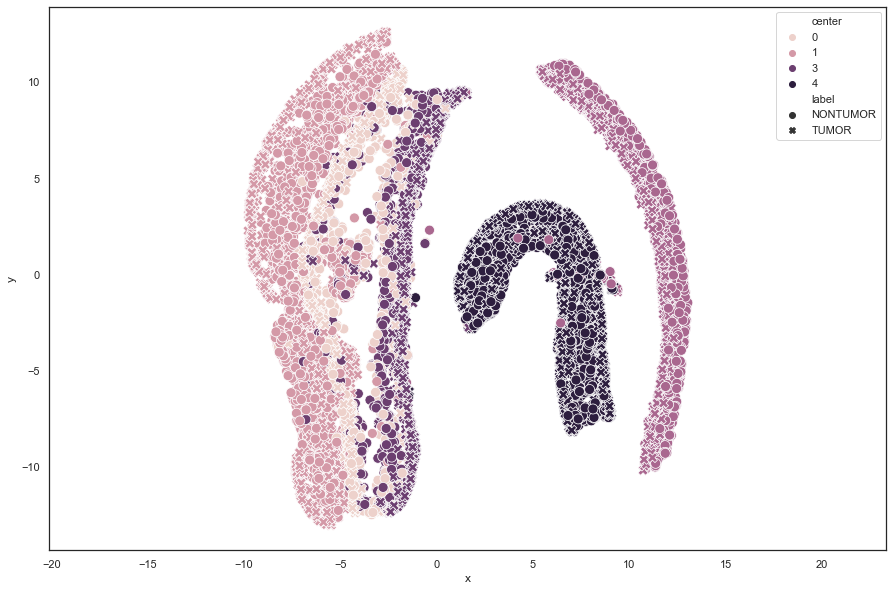

In [96]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='x', y='y', hue='center', style='label', data=df_samples, s=100)#, legend=None)
g = plt.gca().set_aspect('equal', 'datalim')

## Grid sampling

Span a grid over the embedding. Sample uniformly based on this grid.

How to control how many samples are taken? 

Sample based on radius from grid point?

## Mini Batch K-Means

A way of making k-means work for larger samples and more clusters.

The idea is to divide the data into as many clusters as samples we want to take. Then we take only the centroid of each cluster for training.

In [12]:
from sklearn.cluster import MiniBatchKMeans

In [43]:
kmeans = MiniBatchKMeans(n_clusters=10000,
                         random_state=0,
                         batch_size=6,
                         max_iter=10).fit(X)

e:\.venvs\notebooks-bapbuhj6\lib\site-packages\sklearn\cluster\_kmeans.py:1576: RuntimeWarning: init_size=18 should be larger than k=10000. Setting it to 3*k
  init_size=init_size)
e:\.venvs\notebooks-bapbuhj6\lib\site-packages\sklearn\cluster\_kmeans.py:1576: RuntimeWarning: init_size=18 should be larger than k=10000. Setting it to 3*k
  init_size=init_size)
e:\.venvs\notebooks-bapbuhj6\lib\site-packages\sklearn\cluster\_kmeans.py:1576: RuntimeWarning: init_size=18 should be larger than k=10000. Setting it to 3*k
  init_size=init_size)


In [44]:
cluster_centers = kmeans.cluster_centers_

In [100]:
cluster_centers.shape

(10000, 30)

In [45]:
prediciton = kmeans.predict(X)

In [46]:
df_train['kmeans_cluster'] = prediciton

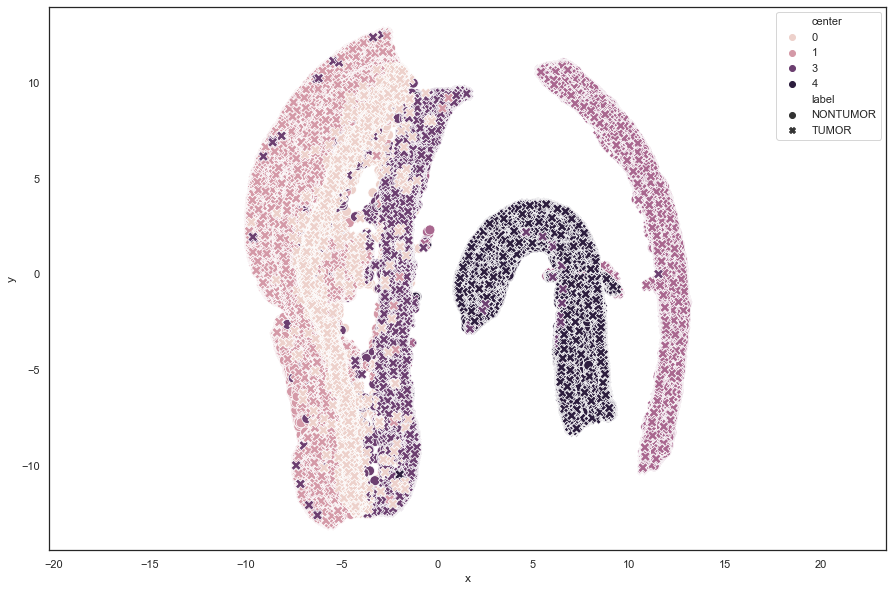

In [97]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='x', y='y', hue='center', style='label', data=df_train, s=100)#, legend=None)
g = plt.gca().set_aspect('equal', 'datalim')

In [48]:
df_train.groupby('kmeans_cluster').size()

kmeans_cluster
0       12
1        2
2        8
3       14
4        7
        ..
9995    15
9996     6
9997    20
9998    14
9999    13
Length: 9997, dtype: int64

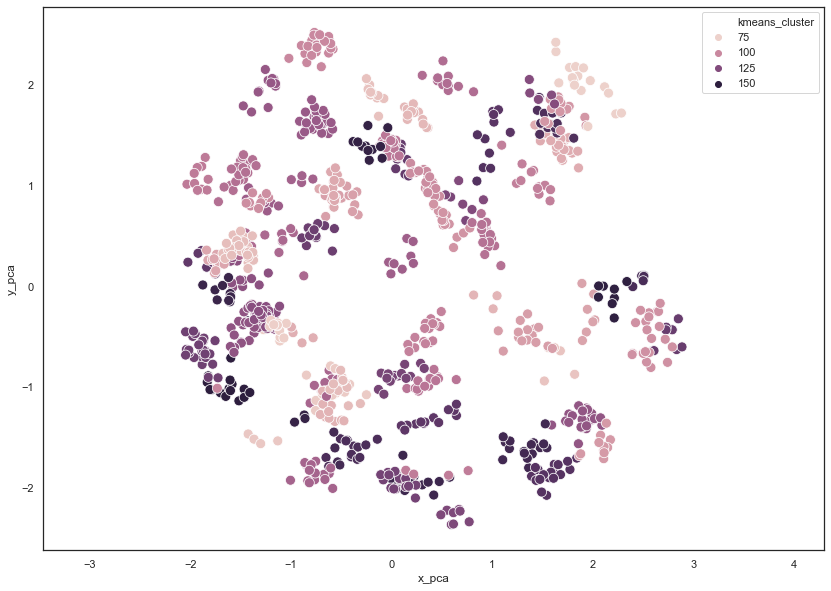

In [64]:
df_tmp = df_train.copy()
df_tmp['x_pca'] = out_array_pca30[:, 0]
df_tmp['y_pca'] = out_array_pca30[:, 1]

sns.scatterplot(x='x_pca', y='y_pca', hue='kmeans_cluster', data=df_tmp[(df_tmp.kmeans_cluster > 75) & (df_tmp.kmeans_cluster < 150)], s=100)#, legend=None)
g = plt.gca().set_aspect('equal', 'datalim')

## Canopy clustering

Plese see https://en.wikipedia.org/wiki/Canopy_clustering_algorithm, http://www.kamalnigam.com/papers/canopy-kdd00.pdf for more information.

A more efficient (but perhaps approximative) way of clustering the data.

In [65]:
# This code was taken from: https://gist.github.com/yumyai/65ecd1f97aaa8f6cfc302fdd4ff0c870

from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

# X shoudl be a numpy matrix, very likely sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix
# T1 > T2 for overlapping clusters
# T1 = Distance to centroid point to not include in other clusters
# T2 = Distance to centroid point to include in cluster
# T1 > T2 for overlapping clusters
# T1 < T2 will have points which reside in no clusters
# T1 == T2 will cause all points to reside in mutually exclusive clusters
# Distance metric can be any from here: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html
# filemap may be a list of point names in their order in X. If included, row numbers from X will be replaced with names from filemap. 
 
def canopy(X, T1, T2, distance_metric='euclidean', filemap=None):
    canopies = dict()
    X1_dist = pairwise_distances(X, metric=distance_metric)
    canopy_points = set(range(X.shape[0]))
    while canopy_points:
        point = canopy_points.pop()
        i = len(canopies)
        canopies[i] = {"c":point, "points": list(np.where(X1_dist[point] < T2)[0])}
        canopy_points = canopy_points.difference(set(np.where(X1_dist[point] < T1)[0]))
    if filemap:
        for canopy_id in canopies.keys():
            canopy = canopies.pop(canopy_id)
            canopy2 = {"c":filemap[canopy['c']], "points":list()}
            for point in canopy['points']:
                canopy2["points"].append(filemap[point])
            canopies[canopy_id] = canopy2
    return canopies

In [67]:
T1 = 1
T2 = 0.6
canopies = canopy(X[:100], T1, T2)

In [98]:
out_array_pca30

array([[-1.6757779 , -0.26308557,  0.23374262, ..., -0.05125214,
         0.12354718, -0.1002982 ],
       [ 0.31853372, -1.9107068 , -0.18090332, ...,  0.12050481,
         0.10172438, -0.1881639 ],
       [ 1.9585018 , -0.9848666 , -0.19470564, ..., -0.08758339,
        -0.01805626, -0.01062254],
       ...,
       [-0.70850587,  1.3618355 ,  0.7990706 , ...,  0.22693202,
        -0.01238643, -0.05978791],
       [ 0.27402452,  0.28813666,  1.3285363 , ..., -0.4599535 ,
         0.01747963,  0.15378286],
       [ 0.03092387,  0.5232995 , -0.65084445, ...,  0.11418095,
         0.21152522,  0.1965575 ]], dtype=float32)